# Text Classification with Naive Bayes 

A [tutorial](https://github.com/udacity/machine-learning/tree/master/projects/practice_projects/naive_bayes_tutorial) from Udacity's Machine Learning Nanodegree Program deals with spam detection using Naive Bayes. Here I start with the same dataset, follow the instructions to write my own solutions in the first part. Then, I implement the Naive Bayes Classifier from scratch from a training set, and make predictions on a test set.  



In [2]:
import pandas as pd 
import numpy as np 

## Data Handling 

Here, the dataset consists of sms messages that are already labeled as spam or ham. Our purpose split this dataset into training and test sets, and to create a Naive Bayes Classifier on the training set. Afterwards, we will use this to predict the labels of the messages in the test set and compare these predictions to the original labels to determine how well we predicted. 

<p> <p/> 

In [3]:
# spam data from https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection 
df = pd.read_table("smsspamcollection/SMSSpamCollection", header=None)
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.rename(columns={df.columns.values[0]:'label', df.columns.values[1]:'sms_message'}, inplace=True)
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.label.replace({'ham': 0, 'spam': 1}, inplace=True)
df.head()

,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Bag of Words 

###  Step1: Convert all letters to lowercase

In [6]:
lower_case_documents = df.sms_message.map(lambda s: s.lower())
print (lower_case_documents.head())

0    go until jurong point, crazy.. available only ...
1                        ok lar... joking wif u oni...
2    free entry in 2 a wkly comp to win fa cup fina...
3    u dun say so early hor... u c already then say...
4    nah i don't think he goes to usf, he lives aro...
Name: sms_message, dtype: object


In [7]:
lower_case_documents = lower_case_documents.tolist()

In [1]:
# lower_case_documents

### Step 2: Remove punctuations

In [8]:
import string 

In [9]:
sans_punctuation_documents = [s.translate(str.maketrans("", "", string.punctuation)) for s in lower_case_documents]
# print (sans_punctuation_documents)

### Step 3: Tokenization

Now we can split the sentences into individual words and store them as a list:

In [10]:
preprocessed_documents = [text.split() for text in sans_punctuation_documents]

In [11]:
preprocessed_documents[24]

['ffffffffff',
 'alright',
 'no',
 'way',
 'i',
 'can',
 'meet',
 'up',
 'with',
 'you',
 'sooner']

### Step 4: Our Vocabulary

In [12]:
# Our vocabulary, basically consists of all the words in our dataset: 

vocabulary = []
for word_list in preprocessed_documents:
    vocabulary = list(set(vocabulary + word_list)) 
print (vocabulary[:50])


['2end', 'ground', 'she', 'winner', 'musical', 'videosound', 'subtoitles', 'difference', 'talked', 'shuhui', 'shows', 'respond', 'headstart', 'murderer', 'apology', 'rimac', 'of£2000', 'lifethis', 'wrking', 'turned', 'laptop', 'ws', 'stop2', 'forevr', 'name', 'nr31', 'wine', 'drama', 'spanish', 'meals', 'already', '500', 'submitting', 'danger', 'chikkugoing', 'cared', '08712101358', 'starts', 'speed', 'kid', 'kanji', 'behalf', 'need', 'shouted', 'kkapo', 'rpl', 'supply', 'pub', 'stick', 'ba']


In [13]:
len(vocabulary)

9661

## Creating a Naive Bayes Classifier

$$ P(y \, | \, x_1, \cdots, x_n) = \frac{P(y) P(x_1, \cdots, x_n \, | \, y)}{P(x_1, \cdots, x_n)} $$

Here, `y` is the class variable. In our case, $y=1$ indicates spam, and $y=0$ indicates not spam. `x_1` through `x_n` are the feature vectors or in our case the "basis" of words in our dictionary.  

Given a set of $j$ number of words in a message, 
we compute the posterior probability that this message is spam as the following:


\begin{align}
P( y=1 \, | \, x_1, \cdots, x_j)  &= \frac{P(y=1) P(x_1, \cdots, x_j \, | \, y=1)}{P(x_1, \cdots, x_j)} \nonumber \\
 &= \frac{P(y=1) P(x_1  \, | \, y=1) \, P(x_2  \, | \,y=1) \cdots P(x_j  \, | \, y=1)}{P(x_1, \cdots, x_j)}  \nonumber \\
 &= \prod_{i}^{i=j} \frac{P(x_i  \, | \, y=1) }{P(x_1, \cdots, x_j)} \nonumber 
\end{align}

<p> <p/> 



Here we use the Naive Bayes assumption that the likelihoods are conditionally independent, such that we can just multiply them together.  

We will determine the likelihoods that appear on the right hand side, e.g. $P(x_1  \, | \, y=1)$ from the spam messages of our training set. Then we will do the same thing for the non-spam messages, e.g. calculate $P(x_1  \, | \, y=0)$. $P(y=1)$ and $P(y=0)$ are straightforward to compute. Eventually, we will use these probabilities to determine both $P(y=1 \, | \,  x_1, \cdots, x_j)$ and $P(y=0 \, | \,  x_1, \cdots, x_j)$ for a particular message in a test set to determine whether it is spam or not spam. 

For example, for the message "I will call you later", we need to plug in the values for 
* $P(\text{I} \,| \, \text{spam})$, $P(\text{will} \,| \, \text{spam})$, $P(\text{call} \,| \, \text{spam})$, $P(\text{you} \,| \, \text{spam})$, $P(\text{later} \,| \, \text{spam})$ 
* $P(\text{I} \,| \, \text{ham})$, $P(\text{will} \,| \, \text{ham})$, $P(\text{call} \,| \, \text{ham})$, $P(\text{you} \,| \, \text{ham})$, $P(\text{later} \,| \, \text{ham})$

that we should determine from the training set, into the formulas above for both spam and ham case and compare both: 


<p> <p/> 


$$ \frac{P(\text{spam} \,| \, \text{I} \, \text{will} \, \text{call} \, \text{you} \, \text{later})}
{P(\text{ham} \,| \, \text{I} \, \text{will} \, \text{call} \, \text{you} \, \text{later}) }
=  \frac{P(\text{spam}) \, P(\text{I} \,| \, \text{spam}) \, P(\text{will} \,| \, \text{spam}) \, P(\text{call} \,| \, \text{spam}) \, P(\text{you} \,| \, \text{spam}) \, P(\text{later} \,| \, \text{spam}) } 
{P(\text{ham}) \, P(\text{I} \,| \, \text{ham}) \, P(\text{will} \,| \, \text{ham}) \, P(\text{call} \,| \, \text{ham}) \, P(\text{you} \,| \, \text{ham}) \, P(\text{later} \,| \, \text{ham}) } $$

 
Since the denominators are the same for both cases, we can ignore calculating these. I put a cutoff such that I assign a message spam only if the ratio between these is greater than $10^4$. Then, I investigate how this value affects my accuracy score by changing the exponent $10^n$, where $ n $ runs from $0$ to $10$.    

<br> <br/>

Let's split our data into a training and a test set; and calculate the conditional probabilities for both spam and ham case for the training data first. Then we will use these probabilities to calculate the probability that a particular message is spam or not in the test set.   



In [14]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(preprocessed_documents, df.label)

### Calculating probabilities for the spam case 

Now we'd like to separate our training set into spam and not spam cases. First we look at the spam cases:

<p> <p/>

In [15]:
spam_pos = [i for i in range(len(y_train)) if y_train.iloc[i] == 1] 
spam_training_messages = [X_train[i] for i in spam_pos]
print (len(spam_training_messages))
print (len(spam_pos))
print (len(y_train))

553
553
4179


<p> <p/> 

The probability of getting a spam message from this training set is then: 


$$ P(spam) = \frac{\text{number of spam messages in the training set}}{\text{number of messages in the training set}} $$ 

<p> <p/> 

In [16]:
probability_spam = len(spam_training_messages) / len(y_train)
print (probability_spam)

0.1323283082077052


<p> <p/> 

Now, we combine all the words appearing in the training set into a list, and then count how many times each word appears in the training set. This will help us calculate the conditional probabilities later. 



<p> <p/> 

In [17]:
vocabulary_training_spam = []
for word_list in spam_training_messages:
    vocabulary_training_spam = list(set(vocabulary_training_spam + word_list)) 
# print (vocabulary_training_spam)

In [18]:
# here we count how many times each word appears in the training set:
from collections import Counter
frequency_list_training_spam = Counter(vocabulary_training_spam)
print (len(frequency_list_training_spam))

2627


In [20]:
# print (frequency_list_training_spam.values())
# print (frequency_list_training_spam[vocabulary[165]])

<br> <br/> 


Now let's calculate the probabilities of each word in the document vocabulary appearing in the spam piece of the training set, specifically, we calculate P(word_1 | spam).

Because some probabilities will turn out zero, we add two fictitous terms to numerator and denominator to "regularize"
the probabilities. Here is a way to do this, it is called Laplace smoothing: 
P(word_1 | spam) = (n_word_1 + 1) / (number of spam documents + number of items in the vocabulary)
Notice that it still holds that the sum of probabilities, which would give P(word_1) is one. 

I change this regularization to: P(word_1 | spam) = (n_word_1 + 10^(-22)) / (number of spam documents)

The reason for this is that the length of our vocabulary is in the order of thousands, while the frequency 
of a word appearing among the spam documents is very low -- just 1 -- this makes for example, P(word_1 | spam) 
extremely small, close to zero, makes it hard to distinguish from a probability for the non-spam case. 
We would like to separate the values of probability of a word appearing or not appearing among spam documents
as far as possible.  



<p> <p/> 

In [21]:

probabilities_training_spam = [(frequency_list_training_spam[vocabulary[i]]) / (len(vocabulary_training_spam)) for i in range(len(vocabulary))] 

probabilities_training_spam_regularized = [(frequency_list_training_spam[vocabulary[i]] + 0.0000000000000000000001) / (len(vocabulary_training_spam)) for i in range(len(vocabulary))] 




In [22]:
set(probabilities_training_spam_regularized)

{3.806623524933384e-26, 0.00038066235249333843}

In [23]:
set(probabilities_training_spam)

{0.0, 0.00038066235249333843}

### Calculating probabilities for the non spam case 

In [24]:
ham_pos = [i for i in range(len(y_train)) if y_train.iloc[i] == 0] 
ham_training_messages = [X_train[i] for i in ham_pos]
print (len(ham_training_messages))
print (len(ham_pos))
print (len(y_train))

3626
3626
4179


In [25]:
# the probability of getting a non spam message from this training set is then: 
# P(ham) = ...
probability_ham = len(ham_training_messages) / len(y_train)
print (probability_ham)

0.8676716917922948


In [26]:
# let's combine all the words appearing in the training set into a list:
vocabulary_training_ham = []
for word_list in ham_training_messages:
    vocabulary_training_ham = list(set(vocabulary_training_ham + word_list)) 
# print (vocabulary_training_ham)

In [27]:
# here we count how many times each word appears in the training set:
from collections import Counter
frequency_list_training_ham = Counter(vocabulary_training_ham)
print (len(frequency_list_training_ham))

6505


In [28]:
# now let's calculate the probabilities of each word in the document vocabulary appearing in the not-spam piece of the training set: 
# specifically, we calculate P(word_1 | ham) = ... 
# because some probabilities will turn out zero, we add two fictitous terms to numerator and denominator to "regularize"
# the probabilities. It is called Laplace smoothing. 
# P(word_1 | ham) = (n_word_1 + 1) / (number of ham documents + number of items in the vocabulary)
# Here I change this regularization to: P(word_1 | ham) = (n_word_1 + 10^(-22)) / (number of ham documents)


probabilities_training_ham = [(frequency_list_training_ham[vocabulary[i]]) / (len(vocabulary_training_ham)) for i in range(len(vocabulary))] 
probabilities_training_ham_regularized = [(frequency_list_training_ham[vocabulary[i]] + 0.0000000000000000000001) / (len(vocabulary_training_ham)) for i in range(len(vocabulary))] 




In [29]:
print (set(probabilities_training_ham_regularized))
print (set(probabilities_training_spam_regularized))
print (set(probabilities_training_ham))
print (set(probabilities_training_spam))

{0.00015372790161414298, 1.5372790161414297e-26}
{0.00038066235249333843, 3.806623524933384e-26}
{0.0, 0.00015372790161414298}
{0.0, 0.00038066235249333843}


In [30]:
print (probabilities_training_spam_regularized[2])
print (probabilities_training_ham_regularized[2])
print (probabilities_training_spam_regularized[2] / probabilities_training_ham_regularized[2])

3.806623524933384e-26
0.00015372790161414298
2.476208602969166e-22


In [31]:
print (len(vocabulary_training_ham))
print (len(set(vocabulary_training_ham)))

6505
6505


In [216]:
# with all the conditional probabilities in hand, we can move on to our test set and start predicting whether a message
# is spam or not. 

### Predicting whether a message is spam or not using our test set 

In [36]:
def predict_spam(messages, n, verbose):
    
    y_labels = []
       
    for message in messages:  
        prob_s = 1 
        prob_h = 1 

        for word in message:
            index = vocabulary.index(word) if word in vocabulary else None
            p_word_spam = probabilities_training_spam_regularized[index]
            p_word_ham = probabilities_training_ham_regularized[index]
            
            if verbose == True:
                print ("p('%s' | spam): %s" % (word, p_word_spam))
                print ("p('%s' | ham): %s" % (word, p_word_ham)) 
            prob_s *= p_word_spam
            prob_h *= p_word_ham

            
        prob_message_spam = prob_s * probability_spam
        prob_message_ham = prob_h * probability_ham

        
        if verbose == True:
            print ("relative probability that this message is spam: %s" % (prob_message_spam))
            print ("relative probability that this message is not spam: %s" % (prob_message_ham))

        

        if prob_message_spam > (10 ** n) * prob_message_ham:
            y_labels.append(1)
            if verbose == True:
                print ("Message is spam!")
                print ("")
        else: 
            y_labels.append(0)
            if verbose == True:
                print ("Message is not spam!")
                print ("")
    
    return y_labels 

    

In [33]:
y_labels = predict_spam(X_test, 4, True)

p('poor' | spam): 3.806623524933384e-26
p('poor' | ham): 0.00015372790161414298
p('girl' | spam): 0.00038066235249333843
p('girl' | ham): 0.00015372790161414298
p('cant' | spam): 0.00038066235249333843
p('cant' | ham): 0.00015372790161414298
p('go' | spam): 0.00038066235249333843
p('go' | ham): 0.00015372790161414298
p('one' | spam): 0.00038066235249333843
p('one' | ham): 0.00015372790161414298
p('day' | spam): 0.00038066235249333843
p('day' | ham): 0.00015372790161414298
p('lmao' | spam): 3.806623524933384e-26
p('lmao' | ham): 0.00015372790161414298
relative probability that this message is spam: 1.5326121023349744e-69
relative probability that this message is not spam: 1.7604525436631185e-27
Message is not spam!

p('just' | spam): 0.00038066235249333843
p('just' | ham): 0.00015372790161414298
p('buy' | spam): 0.00038066235249333843
p('buy' | ham): 0.00015372790161414298
p('a' | spam): 0.00038066235249333843
p('a' | ham): 0.00015372790161414298
p('pizza' | spam): 3.806623524933384e-26


<br> <br/> 



### Accuracy Score 

In [34]:
check_y = [y_labels[i] == y_test.tolist()[i] for i in range(len(y_labels))] 
print (check_y.count(True)) 
print (len(y_labels))
print (check_y.count(True) / len(y_labels))

1362
1393
0.9777458722182341


In [37]:
accuracies = []
n = range(20)

for i in range(20):
    y_i = predict_spam(X_test, i, False);
    check_y_i = [y_i[i] == y_test.tolist()[i] for i in range(len(y_i))]
    accuracy_i = check_y_i.count(True) / len(y_labels)
    accuracies.append(accuracy_i)
       

In [38]:
accuracies

[0.91816223977028,
 0.9253409906676239,
 0.9597989949748744,
 0.9669777458722182,
 0.9777458722182341,
 0.9777458722182341,
 0.9784637473079684,
 0.9777458722182341,
 0.9763101220387652,
 0.9755922469490309,
 0.9748743718592965,
 0.9741564967695621,
 0.9741564967695621,
 0.9741564967695621,
 0.9741564967695621,
 0.9741564967695621,
 0.9741564967695621,
 0.9741564967695621,
 0.9741564967695621,
 0.9741564967695621]

In [39]:
import matplotlib.pyplot as plt 
%matplotlib inline 

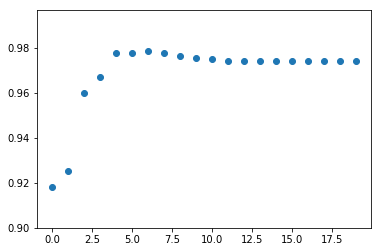

In [40]:
n = range(20)
plt.scatter(n, accuracies)